In [168]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
import seaborn as sns

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']

# Load data

In [169]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

Naive dataset

In [170]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

# Parameters needed for cross validation

In [171]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Functions

In [172]:
def find_net_benefit(y_probabilities, y_true, omega_sequences):   
    net_benefit_by_omega = {}
    for omega in omega_sequences:
        p = omega/(1 + omega)        
        y_predict_test = np.where(y_probabilities[:, 1] > p, 1, 0)

        tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


        net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * omega)

        net_benefit_by_omega[omega] =  net_benefit
    return net_benefit_by_omega

def get_heatmap_data_for_omega_optimal_threshold(NB_data, weeks_to_predict):
        heatmap_data_omega = pd.DataFrame()
        
        for week in range(1, weeks_to_predict[-1]):
                weekly_data = NB_data[week].values()
                #weekly_data = list(reversed(weekly_data))
                heatmap_data_omega[week] = weekly_data
        return heatmap_data_omega

# Calculate the net benefit at every optimal threshold 

In [190]:
omega_sequences = np.linspace(0,4,401)
threshold_sequences = []
for omega in omega_sequences:
    threshold_sequences.append((omega/(1 + omega)))
threshold_sequences = [round(threshold, 2) for threshold in threshold_sequences]


In [191]:
new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_training_set/'
os.chdir(new_directory)
net_benefit_by_omega_p_full_period = {}
net_benefit_by_model_omega_p_period_naive = {}
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

for prediction_week in weeks_to_predict:

        # Full model
        model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
        clf_full_period = pickle.load(open(model_name_to_load, 'rb'))


        X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        
        X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        weights_full_period = weights_full[0].to_numpy()

        clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full_period)

        # Make predictions on the test set
        y_pred = clf_full_period.predict(X_test_full)

        y_pred_proba = clf_full_period.predict_proba(X_test_full)
        y_pred_positive_proba = y_pred_proba[:, 1] 
        net_benefit_by_omega_week_period = find_net_benefit(y_pred_proba, y_test_full, omega_sequences)
        net_benefit_by_omega_p_full_period.__setitem__(prediction_week, net_benefit_by_omega_week_period)  


        # Naive model 
        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        
        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as is the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model

        conf_matrix = confusion_matrix(y_test_naive, y_pred)

        net_benefit_by_omega_week_period_naive = find_net_benefit(y_pred_proba, y_test_naive, omega_sequences)
        net_benefit_by_model_omega_p_period_naive.__setitem__(prediction_week, net_benefit_by_omega_week_period_naive)



/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_96245/1081505292.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_96245/1081505292.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_96245/2149217628.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

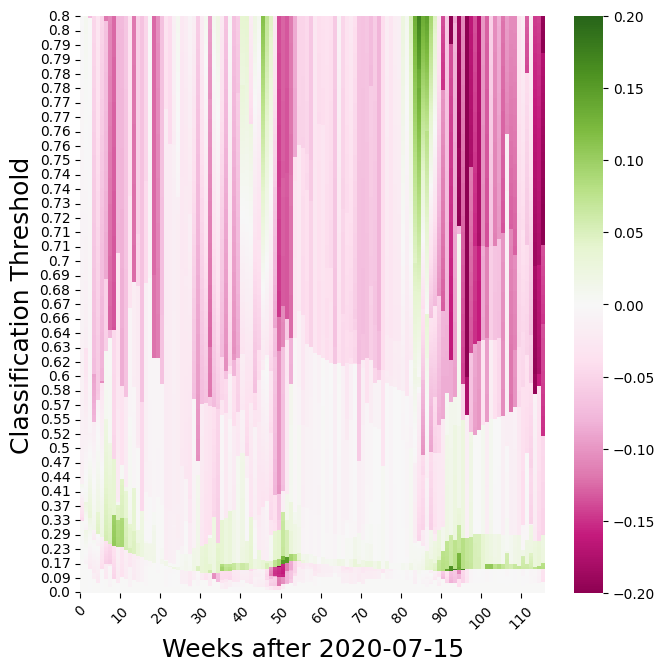

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
omega_sequences = np.linspace(0,4,401)
threshold_sequences = []
for omega in omega_sequences:
    threshold_sequences.append((omega/(1 + omega)))
threshold_sequences = [round(threshold, 2) for threshold in threshold_sequences]
heatmap_data_naive_period = get_heatmap_data_for_omega_optimal_threshold(net_benefit_by_model_omega_p_period_naive, weeks_to_predict);  

heatmap_data_full_period = get_heatmap_data_for_omega_optimal_threshold(net_benefit_by_omega_p_full_period, weeks_to_predict);  
#gain_NB_full_vs_naive_all_omega.reset_index(inplace=True, drop = True)
gain_NB_full_vs_naive = heatmap_data_full_period.subtract(heatmap_data_naive_period)
gain_NB_full_vs_naive['threshold_sequences'] = threshold_sequences
gain_NB_full_vs_naive.set_index('threshold_sequences', inplace=True)
sns.heatmap((gain_NB_full_vs_naive), annot=False, cmap='PiYG', vmin = -.2, vmax = 0.2)
ax.invert_yaxis()

ax.set_xticks(range(0, 120, 10))
x_labels = range(0, 120, 10)
ax.set_xticklabels(x_labels, rotation=45)

ax.set_xlabel('Weeks after 2020-07-15', fontsize=18)
ax.set_ylabel("Classification Threshold", fontsize=18)
plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Net_benefit_full_naive_expanding_train_models_period_{size_of_test_dataset}_week_min_fp.png', dpi = 300)

## Net benefit to minimise false negatives

In [173]:
def find_net_benefit_min_negatives(y_probabilities, y_true, omega_sequences):   
    net_benefit_by_omega = {}
    for omega in omega_sequences:
        p = 1/(1 + omega)        
        y_predict_test = np.where(y_probabilities[:, 1] > p, 1, 0)

        tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


        net_benefit = tn/(len(y_true)) - (fn/(len(y_true)) * omega)

        net_benefit_by_omega[omega] =  net_benefit
    return net_benefit_by_omega


In [196]:
omega_sequences = np.linspace(0,4,401)

threshold_sequences = []
for omega in omega_sequences:
    threshold_sequences.append((1/(1 + omega)))
threshold_sequences = [round(threshold, 2) for threshold in threshold_sequences]

In [176]:
net_benefit_by_omega_p_full_period_min_negative = {}
net_benefit_by_model_omega_p_period_naive_min_negative = {}
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)

for prediction_week in weeks_to_predict:

        # Full model
        model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
        clf_full_period = pickle.load(open(model_name_to_load, 'rb'))


        X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        
        X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        weights_full_period = weights_full[0].to_numpy()

        clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full_period)

        # Make predictions on the test set
        y_pred = clf_full_period.predict(X_test_full)

        y_pred_proba = clf_full_period.predict_proba(X_test_full)
        y_pred_positive_proba = y_pred_proba[:, 1] 
        net_benefit_by_omega_week_period = find_net_benefit_min_negatives(y_pred_proba, y_test_full, omega_sequences)
        net_benefit_by_omega_p_full_period_min_negative.__setitem__(prediction_week, net_benefit_by_omega_week_period)  


        # Naive model 
        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        
        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as is the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model

        conf_matrix = confusion_matrix(y_test_naive, y_pred)

        net_benefit_by_omega_week_period_naive = find_net_benefit_min_negatives(y_pred_proba, y_test_naive, omega_sequences)
        net_benefit_by_model_omega_p_period_naive_min_negative.__setitem__(prediction_week, net_benefit_by_omega_week_period_naive)


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_96245/1081505292.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_96245/1081505292.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_96245/2242779045.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

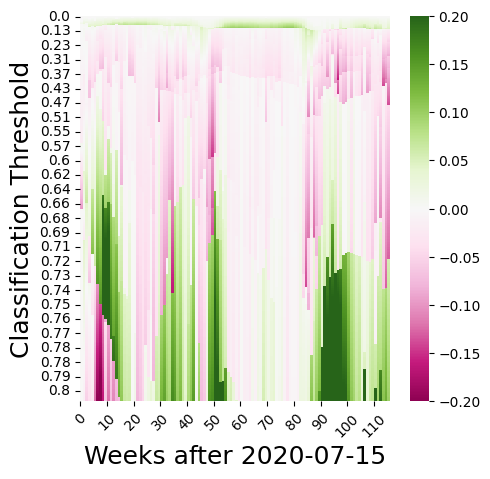

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
heatmap_data_naive_period_min_negative = get_heatmap_data_for_omega_optimal_threshold(net_benefit_by_model_omega_p_period_naive_min_negative, weeks_to_predict);  

heatmap_data_full_period_min_negative = get_heatmap_data_for_omega_optimal_threshold(net_benefit_by_omega_p_full_period_min_negative, weeks_to_predict);  
#gain_NB_full_vs_naive_all_omega.reset_index(inplace=True, drop = True)
gain_NB_full_vs_naive_min_negative = heatmap_data_full_period_min_negative.subtract(heatmap_data_naive_period_min_negative)
gain_NB_full_vs_naive_min_negative['threshold_sequences'] = threshold_sequences
gain_NB_full_vs_naive_min_negative.set_index('threshold_sequences', inplace=True)
sns.heatmap((gain_NB_full_vs_naive_min_negative.T).T, annot=False, cmap='PiYG', vmin = -.2, vmax = 0.2)
#sns.heatmap((gain_NB_full_vs_naive_min_negative), annot=False, cmap='PiYG', vmin = -.2, vmax = 0.2)

#ax.invert_yaxis()
#y_tick_locations = np.linspace(0,4,401)*100
#y_labels = threshold_sequences
#y_labels = y_labels[::-1][::40]  # Get every 10th label
#ax.set_yticks(y_tick_locations[::40])
#ax.set_yticklabels(y_labels, rotation=90)
ax.set_xticks(range(0, 120, 10))
x_labels = range(0, 120, 10)
ax.set_xticklabels(x_labels, rotation=45)

ax.set_xlabel('Weeks after 2020-07-15', fontsize=18)
ax.set_ylabel("Classification Threshold", fontsize=18)

plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Net_benefit_full_naive_expanding_train_models_period_{size_of_test_dataset}_week_min_fn.png', dpi = 300)

In [131]:
threshold_sequences

[1.0,
 0.99,
 0.98,
 0.97,
 0.96,
 0.95,
 0.94,
 0.93,
 0.93,
 0.92,
 0.91,
 0.9,
 0.89,
 0.88,
 0.88,
 0.87,
 0.86,
 0.85,
 0.85,
 0.84,
 0.83,
 0.83,
 0.82,
 0.81,
 0.81,
 0.8,
 0.79,
 0.79,
 0.78,
 0.77,
 0.77,
 0.76,
 0.76,
 0.75,
 0.75,
 0.74,
 0.73,
 0.73,
 0.72,
 0.72,
 0.71,
 0.71,
 0.7,
 0.7,
 0.69,
 0.69,
 0.68,
 0.68,
 0.67,
 0.67,
 0.67,
 0.66,
 0.66,
 0.65,
 0.65,
 0.64,
 0.64,
 0.64,
 0.63,
 0.63,
 0.62,
 0.62,
 0.62,
 0.61,
 0.61,
 0.6,
 0.6,
 0.6,
 0.59,
 0.59,
 0.59,
 0.58,
 0.58,
 0.58,
 0.57,
 0.57,
 0.57,
 0.56,
 0.56,
 0.56,
 0.55,
 0.55,
 0.55,
 0.55,
 0.54,
 0.54,
 0.54,
 0.53,
 0.53,
 0.53,
 0.53,
 0.52,
 0.52,
 0.52,
 0.51,
 0.51,
 0.51,
 0.51,
 0.5,
 0.5,
 0.5,
 0.5,
 0.49,
 0.49,
 0.49,
 0.49,
 0.48,
 0.48,
 0.48,
 0.48,
 0.47,
 0.47,
 0.47,
 0.47,
 0.47,
 0.46,
 0.46,
 0.46,
 0.46,
 0.46,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.44,
 0.44,
 0.44,
 0.44,
 0.44,
 0.43,
 0.43,
 0.43,
 0.43,
 0.43,
 0.42,
 0.42,
 0.42,
 0.42,
 0.42,
 0.42,
 0.41,
 0.41,
 0.41,
 0.4